In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# from package import batch_gd, new_labels, report, convert_labels
from util import vcpi_util

----
# Global Variables


In [12]:
HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
BATCH_SIZE = 128
LATENT_SPACE_DIM = 2

MODEL_PATH = 'model_result'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Sample and Explore

We will be using the dataset provided of the GTSRB (German Traffic Sign Recognition Benchmark) to train a model to recognize traffic signs. The dataset consists of 43 classes of traffic signs and is already split into training and testing sets.

-  We defined the standard size of the images to be 32 by 32 which is the size of the smaller images in the dataset and since we have very low computational power we decided to keep the size of the images small.

In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize([32, 32]), # Resize images to 32x32
    transforms.ToTensor() # Convert images to torch Tensors and rescale pixels to [0, 1]
])

# Import datasets from the directory
train_dataset = datasets.ImageFolder(root='./train_images', transform=transform)
test_dataset = datasets.ImageFolder(root='./test_images', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



# Length of the train and test datasets
print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

# Check the number of classes in the train and test datasets
print(f'Number of classes in training set: {len(train_dataset.classes)}')
print(f'Number of classes in test set: {len(test_dataset.classes)}')

# Verify class distribution
# print(f'Class distribution in training set: {train_dataset.class_to_idx}')
# print(f'Class distribution in test set: {test_dataset.class_to_idx}')

Training set size: 39209
Test set size: 12630
Number of classes in training set: 43
Number of classes in test set: 43


# Pre-computing Labels

In [14]:


# # Save labels to files to reduce I/O overhead during analysis
# train_labels = []
# for _, y in train_loader:
#     train_labels.extend(y.numpy())

# test_labels = []
# for _, y in test_loader:
#     test_labels.extend(y.numpy())


# np.save('cache/train_labels.npy', np.array(train_labels))
# np.save('cache/test_labels.npy', np.array(test_labels))



Image shape: torch.Size([128, 3, 32, 32]), label shape: torch.Size([128])
Min and max pixel values: [0.019607843831181526, 1.0]
Number of classes 42


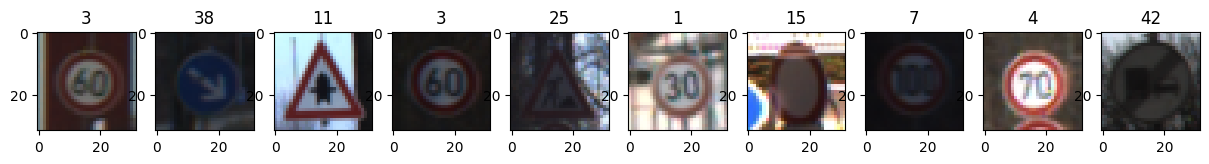

In [15]:
# Visualize random images from the training set
for x, y in train_loader:

    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')

    figure, axis = plt.subplots(1, 10, figsize=(15,15))

    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

We verify that the number of classes is 43 and that the number of images in the training and testing sets is 34799 and 12630 respectively. 
- Since the number of classes is relatively large, we can try to group the classes into fewer categories to simplify the problem. 
- We can also try to use data augmentation to increase the number of images in the training set. This will help the model generalize better and prevent overfitting.
- We can also note that the images have very different brightness and contrast levels. We should try to normalize the images to make the model more robust to these variations.

# Data Preprocessing

In [16]:
# Load precomputed labels
train_labels = np.load('cache/train_labels.npy')
test_labels = np.load('cache/test_labels.npy')

# Plotting the distribution
fig = px.histogram(train_labels, text_auto=True, title="Training samples distribution for the new classes")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
def plot_distrib(path:str, title:str):
    df = pd.read_csv(path, sep=',', index_col=0)
    fig = px.histogram(df.values, text_auto=True, title=title)
    fig.show()
plot_distrib(path='data/train_labels.csv', title="Training samples distribution")
plot_distrib(path='data/test_labels.csv', title="Testing samples distribution")